# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [67]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import os.path
import helpers as h
from itertools import islice
from ast import literal_eval
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.util.testing import assert_frame_equal
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [91]:
# Load all functions used later in this block. I am consolidating these to this block since I want to be able to run
# imports and functions at once so I can skip to different areas of the code when troubleshooting
# Get invalid values for certain column name returned as an array
def get_invalid_values(feat_info, column_name):
    # Get 'invalid values' for that feature
    # Note: the 'loc' function casts values to floats because the columns have a combination of ints and floats
    # It doesn't not change the intrinsic numeric value of the cell
    invalid_values = feat_info.loc[(feat_info['attribute']==column_name),'missing_or_unknown']
    if invalid_values.empty or invalid_values.iloc[0]=='[]': return []
    
    # If it exists, convert it to a usable array
    # First sanitize it to all strings since some arrays have a combination of strings and integers
    # This is an issue because certain missing_or_unknown values are displayed as:
    # [-1,XX], [-1,X], [XX]
    return invalid_values.iloc[0].replace('[','').replace(']','').split(',')

def replace_invalid_values(data_frame, feat_info):
    for column in data_frame:
        invalid_values = get_invalid_values(feat_info, column)
        for invalid_value in invalid_values:
            # Sanitize for X and XX values
            invalid_value = float(invalid_value) if invalid_value.lstrip('-').isnumeric() else invalid_value
            data_frame[column] = data_frame[column].replace(invalid_value, np.nan)
    return data_frame

def nan_sums_df(data_frame):
    # How much data is missing in each row of the dataset?
    nan_sums_per_row = data_frame.isnull().sum(axis=1)

    # Convert to DataFrame so it's easier to plot
    nan_sums_df = pd.DataFrame({'missing_count':nan_sums_per_row.values})
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.

    # Threshold for split of data; starting with at least fifty percent existing
    threshold = len(data_frame.columns) / 2

    nan_sums_low = nan_sums_df[nan_sums_df['missing_count']<threshold]
    nan_sums_high = nan_sums_df[nan_sums_df['missing_count']>=threshold] # Outliers
    
    return nan_sums_low, nan_sums_high

# Check if column is binary and numeric
# Returns 'multi-level', 'non-binary', 'numeric' or 'non-numeric'
def check_binary_and_numeric(data_frame, column_name):
    # Calculate how many unique values are in each column; we are looking for columns with 2 (i.e. binary)
    num_unique = data_frame[column_name].nunique()
    if num_unique > 2: return 'multi-level'
    if num_unique != 2: return 'non-binary' # all others that aren't binary
    if is_numeric_dtype(data_frame[column_name]): return 'numeric'
    if is_string_dtype(data_frame[column_name]): return 'non-numeric'
    
    return 'error'

def variable_categories(data_frame, feat_info):
    # Get all column names where type is 'categorical'
    categorical_variables = feat_info[feat_info.type=='categorical']['attribute']
    
    # Filter out column names that were already removed from the dataset
    categorical_variables = [categorical_v for categorical_v in categorical_variables if categorical_v in data_frame.columns]
    
    multi_level_list = []
    non_binary_list = []
    numeric_list = []
    non_numeric_list = []

    for categorical_v in categorical_variables:
        check_column = check_binary_and_numeric(data_frame, categorical_v)
        
        if check_column == 'multi-level':
            multi_level_list.append(categorical_v)
            continue

        if check_column == 'non-binary':
            non_binary_list.append(categorical_v)
            continue

        if check_column == 'numeric':
            numeric_list.append(categorical_v)
            continue

        if check_column == 'non-numeric':
            non_numeric_list.append(categorical_v)
            continue

        raise("There was an error. Please check data.")
    
    return multi_level_list, non_binary_list, numeric_list, non_numeric_list

def get_ones_and_tens(row, ones=False):
    number_value = row['CAMEO_INTL_2015']
    
    if math.isnan(float(number_value)):
        return np.nan
    
    assert len(number_value) == 2, "Numbers should be two digits."
    
    split_num = [int(num) for num in str(number_value)]
        
    return split_num[0] if ones==False else split_num[1]

def data_frame_unit_test(data_frame, outliers, multi_level_list, encoded_column_names):
    mixed_type = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']
    removed_columns = mixed_type + outliers + multi_level_list

    # Make sure columns were dropped successfully
    assert 'CAMEO_INTL_2015' not in data_frame.columns, "CAMEO_INTL_2015 column should have previously been removed."
    assert 'PRAEGENDE_JUGENDJAHRE' not in data_frame.columns, "PRAEGENDE_JUGENDJAHRE column should have previously been removed."
    assert not set(multi_level_list).issubset(data_frame.columns)
    assert not set(outliers).issubset(data_frame.columns)

    # Process unchanged columns and assert their presence
    unchanged_columns = feat_info[
        ~(
            (feat_info.type=='numeric') | 
            (feat_info.type=='interval') | 
            (feat_info.type=='ordinal')
         )
    ]['attribute']

    unchanged_columns = unchanged_columns[~unchanged_columns.isin(removed_columns)]

    assert set(unchanged_columns).issubset(data_frame.columns)

    # Check for binary one hot encoded columns
    try:
        assert set(encoded_column_names).issubset(data_frame.columns)
    except:
        print("Encoded column names do not match data frame. Printing encoded values not in full column set below:")
        print([item for item in encoded_column_names if item not in list(data_frame.columns.values)])
        
def get_encoded_column_names(data_frame, multi_level_list):
    encoded_column_names = []
    for multi_level in multi_level_list:
        unique_values = data_frame[multi_level].dropna().unique()
        for unique_value in unique_values:
            encoded_column_names.append(str(multi_level) + '_' + str(unique_value))
    
    return encoded_column_names

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS subset num of column: " + str(len(azdias.columns)))
print("AZDIAS num of rows: " + str(len(azdias)))
display(azdias.head())

print("===================================\n")

print("AZDIAS features subset num of column: " + str(len(feat_info.columns)))
print("AZDIAS features num of rows: " + str(len(feat_info)))
display(feat_info)


AZDIAS subset num of column: 85
AZDIAS num of rows: 891221


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0



AZDIAS features subset num of column: 4
AZDIAS features num of rows: 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
# Confirm that the 'XX' values are correct sinc they seem strange in the data
get_xx_values = azdias.loc[azdias['CAMEO_DEU_2015']=='XX', ['CAMEO_DEU_2015']]
get_xx_values.head()

,CAMEO_DEU_2015
2511,XX
4569,XX
9803,XX
16700,XX
16883,XX


In [6]:
# Find the value of cells already displaying NaN (is it a string, a Numpy NaN, etc.?)
# The column PLZ8_ANTG1 in the first row has a NaN value so we'll deconstruct that
nan_value = azdias.iloc[0]['PLZ8_ANTG1']
print(type(nan_value))
print(nan_value=='nan')
print(nan_value=='NaN')
print(nan_value==np.nan)
print(math.isnan(nan_value)) # Bingo...

<class 'numpy.float64'>
False
False
False
True


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
'''
Based on the amount of data, I am going to find the columns with the most invalid values,
drop them and then convert the invalid values in the DataFrame to NaN. This will allow us
to perform the operations on only the data we need to operate on.
'''

'\nBased on the amount of data, I am going to find the columns with the most invalid values,\ndrop them and then convert the invalid values in the DataFrame to NaN. This will allow us\nto perform the operations on only the data we need to operate on.\n'

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '>' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects
  result = result.union(other)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7397: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '>' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


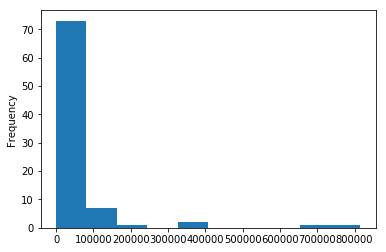

In [8]:
# First get the missing or unknown value counts from each column
azdias_value_counts = azdias.apply(pd.value_counts)

row_list = []
for column in azdias_value_counts:
    # Get this columns invalid values
    invalid_values = get_invalid_values(feat_info, column)
    
    # Iterate through each invalid value and find counts
    missing_count = 0
    for invalid_value in invalid_values:
        # Sanitize for X and XX values
        invalid_value = float(invalid_value) if invalid_value.lstrip('-').isnumeric() else invalid_value
        invalid_value_count = azdias_value_counts.loc[invalid_value][column]
        missing_count += invalid_value_count if not math.isnan(invalid_value_count) else 0
    
    row_list.append(missing_count)

missing_indexer = pd.Series(row_list, index=azdias_value_counts.columns)
missing_indexer.plot.hist()

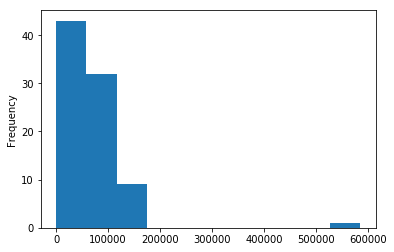

In [9]:
nan_indexer = azdias.isna().sum()
nan_indexer.plot.hist()

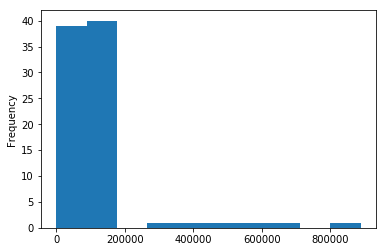

In [10]:
value_list = []
for key, value in nan_indexer.items():
    value_list.append(missing_indexer[key] + nan_indexer[key])

combined_indexer = pd.Series(value_list, index=azdias.columns)
combined_indexer.plot.hist()

In [11]:
# Based on the combined histogram, let's pick columns that have over 200,000 missing values
outliers = combined_indexer[combined_indexer>200000].keys().tolist()
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(outliers, axis=1, inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# Now we will replace the invalid values with Numpy NaN
azdias = replace_invalid_values(azdias, feat_info)

In [14]:
# Check for NaN values to validate
# I'm referencing the early cell when I checked the XX values of CAMEO_DEU_2015. We want them to all return NaN now:
# 2511   XX
# 4569   XX
# 9803   XX
# 16700  XX
# 16883  XX

assert math.isnan(azdias.iloc[2511]['CAMEO_DEU_2015'])
assert math.isnan(azdias.iloc[4569]['CAMEO_DEU_2015'])
assert math.isnan(azdias.iloc[9803]['CAMEO_DEU_2015'])
assert math.isnan(azdias.iloc[16700]['CAMEO_DEU_2015'])
assert math.isnan(azdias.iloc[16883]['CAMEO_DEU_2015'])

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are six columns that appeared to be significant outliers (i.e. had lots of NaN OR missing data):

AGER_TYP  
GEBURTSJAHR  
TITEL_KZ  
ALTER_HH  
KK_KUNDENTYP  
KBA05_BAUMAX  

This were all removed from the data.

There was a decent amount of missing data in the other columns but it was relatively consistent so we will proceed by accepting that margin of error in the data. When investigating the frequency of missing data in the columns after combining both NaN and missing_or_unknown data, there were only six (of eighty five) columns that had over 200,000 missing cells of data so we determined those were outliers.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
nan_sums_low, nan_sums_high = nan_sums_df(azdias)

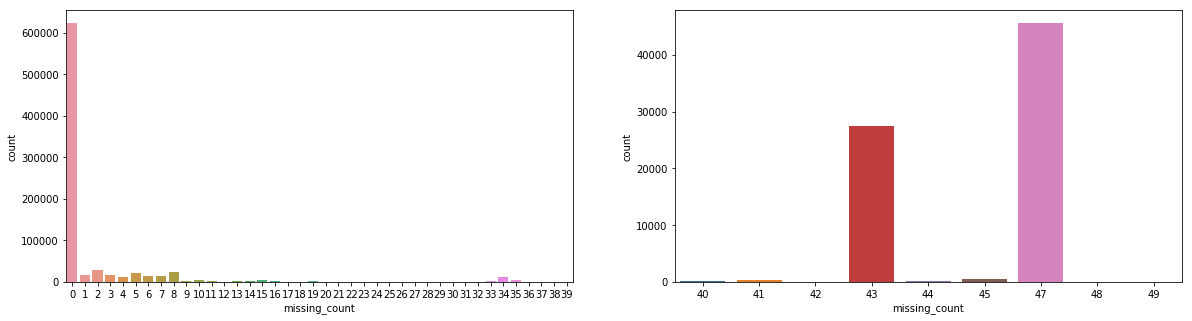

In [16]:
# Display frequencies of missing values
fig, ax = plt.subplots(1,2,figsize=(20, 5))
sns.countplot(x='missing_count',data=nan_sums_low, ax=ax[0])
sns.countplot(x='missing_count',data=nan_sums_high, ax=ax[1])

In [17]:
def plot_side_by_side_column(column):
    fig, ax = plt.subplots(1,2,figsize=(20, 5))
    sns.countplot(azdias.loc[nan_sums_low.index,column], ax=ax[0]).set_title('Few or no missing')
    sns.countplot(azdias.loc[nan_sums_high.index,column], ax=ax[1]).set_title('Many missing')

In [18]:
# Find five columns that have a very low percentage of missing values
# Pull columns with no missing values and see there are enough
non_outliers = combined_indexer[combined_indexer==0]
compare_columns = non_outliers.sample(n=5).index.tolist()
print(compare_columns)

['SEMIO_ERL', 'SEMIO_RAT', 'SEMIO_KULT', 'SEMIO_VERT', 'SEMIO_FAM']


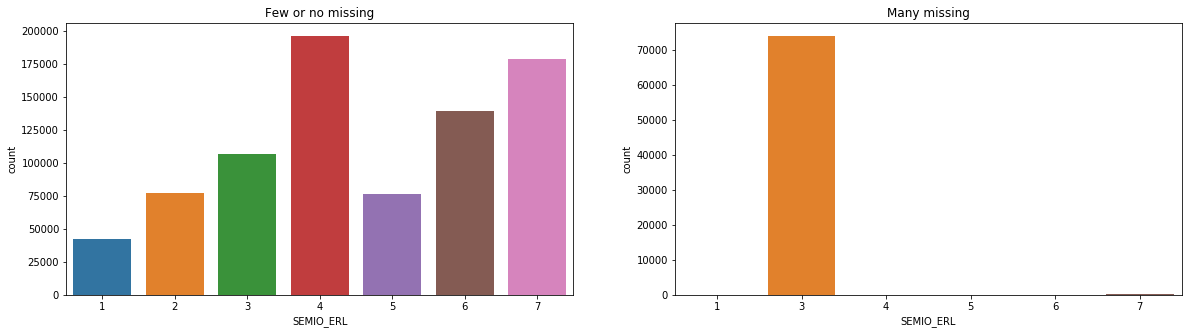

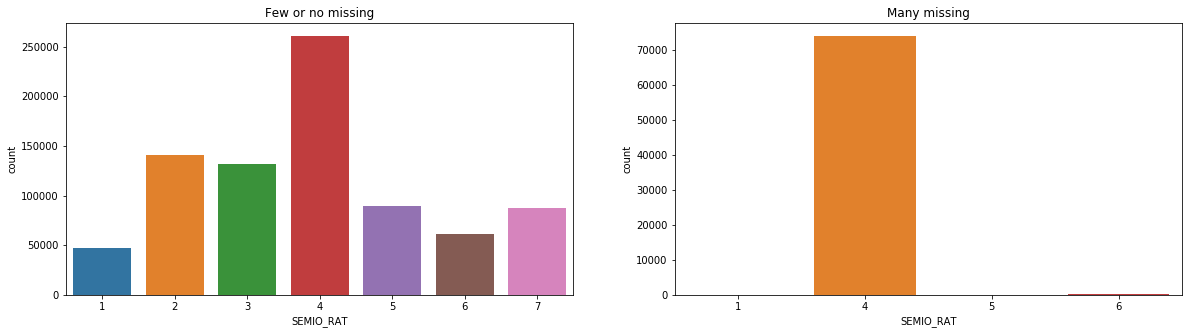

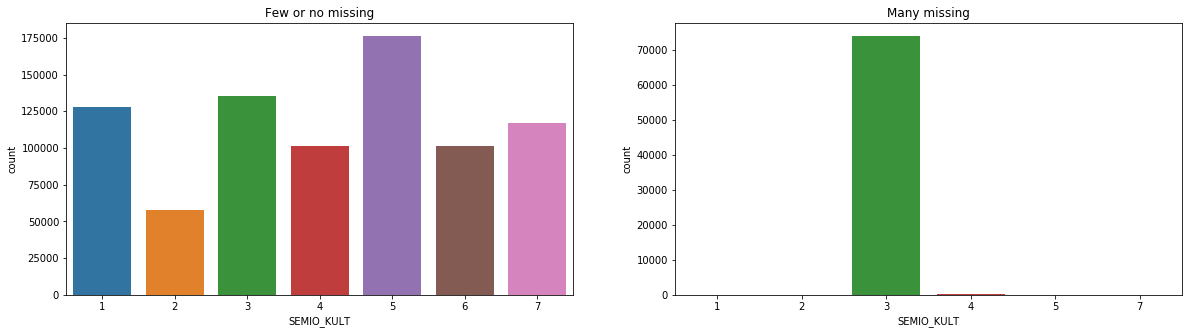

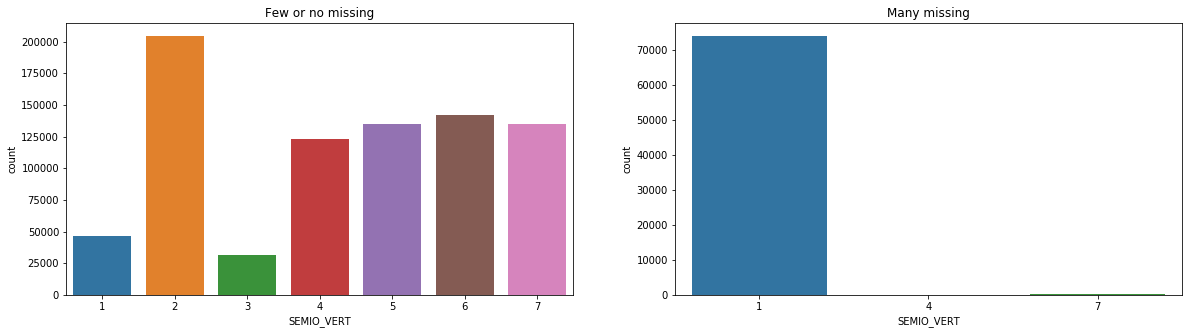

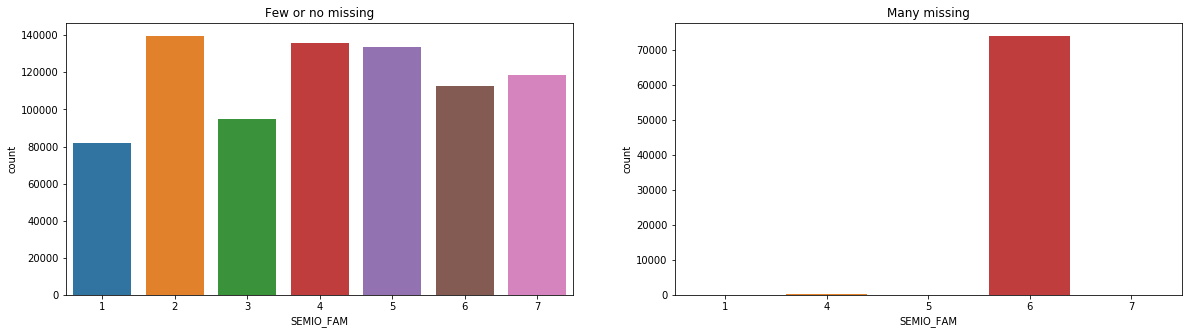

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for i in range(len(compare_columns)):   
    plot_side_by_side_column(compare_columns[i])

In [20]:
# Prune off a portion of the full dataset to run analysis on moving forward
print("Before length: " + str(len(azdias)))
azdias = azdias.loc[nan_sums_low.index]
print("After length: " + str(len(azdias)))

Before length: 891221
After length: 817108


#### Discussion 1.1.3: Assess Missing Data in Each Row

It appears that most of the comparisons are showing qualitatively different output of distributions of values. The rows with many missing values tend to all be very similar with the values of each column. The ones with few or no missing values are distributed more evenly between the values that are displayed.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
feat_third_column = feat_info.iloc[:,[2]]
measurement_types = feat_third_column['type'].unique()
print(measurement_types)

['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

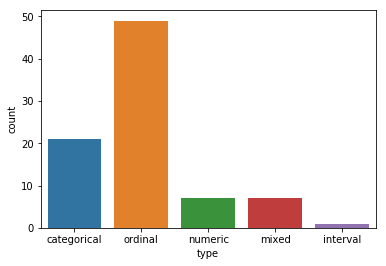

In [22]:
# How many features are there of each data type?
sns.countplot(x='type',data=feat_third_column)
feat_third_column.type.value_counts()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

multi_level_list, non_binary_list, numeric_list, non_numeric_list = variable_categories(azdias, feat_info)

ANREDE_KZ
numeric
CJT_GESAMTTYP
multi-level
FINANZTYP
multi-level
GFK_URLAUBERTYP
multi-level
GREEN_AVANTGARDE
numeric
LP_FAMILIE_FEIN
multi-level
LP_FAMILIE_GROB
multi-level
LP_STATUS_FEIN
multi-level
LP_STATUS_GROB
multi-level
NATIONALITAET_KZ
multi-level
SHOPPER_TYP
multi-level
SOHO_KZ
numeric
VERS_TYP
numeric
ZABEOTYP
multi-level
GEBAEUDETYP
multi-level
OST_WEST_KZ
non-numeric
CAMEO_DEUG_2015
multi-level
CAMEO_DEU_2015
multi-level


In [24]:
print("# of multi level: " + str(len(multi_level_list)))
print("# of non binary: " + str(len(non_binary_list)))
print("# of numeric: " + str(len(numeric_list)))
print("# of non_numeric: " + str(len(non_numeric_list)))

# of multi level: 13
# of non binary: 0
# of numeric: 4
# of non_numeric: 1


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Non-numeric column
non_numeric_column = non_numeric_list[0]
unique_values = azdias[non_numeric_column].dropna().unique().tolist()

# We'll update the two values with integers 1 and 2 (not using 0 and 1 since 0 can be interpretted as False in Boolean comparisons)
azdias[non_numeric_column].replace(unique_values,[1,2], inplace=True)

In [26]:
# Get values that should result for each column we are going to one hot encode to validate their successful creation
encoded_column_names = get_encoded_column_names(azdias, multi_level_list)

# One hot encode multi-level list. Get_dummies is the way to do this in pandas
azdias = pd.get_dummies(azdias, columns=multi_level_list)

In [27]:
# Assert that the encoded_column_names now exist
assert set(encoded_column_names).issubset(azdias.columns), "One hot encoded column names should now be in the main data."

#### Discussion 1.2.1: Re-Encode Categorical Features

Here are the types and frequencies of types of categorical features:

Multi level: 13
Numeric binary: 4
Non-numeric binary: 1

I chose to keep the multi-level columns in the dataset and use get_dummies to one-hot encode them since there were quite a few columns (13 is significant in this dataset).

For the non-numeric binary column, I chose to use the values 1 and 2 to replace the two string characters being used. I would normally use 0 and 1 but in this case, with so many NaN values, I didn't want any confusion when using 0 since it can be interpretted as null, False, etc. when doing truthy comparisons.

All multi-level columns that were one hot encoding after the process was complete were dropped by the get_dummies function to minimize the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias['PRAEGENDE_JUGENDJAHRE'].unique())

[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


In [29]:
# From Data_Dictionary.md
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

def decade_movement(number):
    if math.isnan(number):
        number = 0
    
    # Mainstream = 1
    # Avantgrade = 2
    
    # All decades remain, except 0 stripped from end to use less bytes
    data_definitions = {
        -1 : {
            'decade':0,
            'movement':0
        },
        0 : {
            'decade':0,
            'movement':0
        },
        1 : {
            'decade':4,
            'movement':1
        },
        2 : {
            'decade':4,
            'movement':2
        },
        3 : {
            'decade':5,
            'movement':1
        },
        4 : {
            'decade':5,
            'movement':2
        },
        5 : {
            'decade':6,
            'movement':1
        },
        6 : {
            'decade':6,
            'movement':2
        },
        7 : {
            'decade':6,
            'movement':2
        },
        8 : {
            'decade':7,
            'movement':1
        },
        9 : {
            'decade':7,
            'movement':2
        },
        10 : {
            'decade':8,
            'movement':1
        },
        11 : {
            'decade':8,
            'movement':2
        },
        12 : {
            'decade':8,
            'movement':1
        },
        13 : {
            'decade':8,
            'movement':2
        },
        14 : {
            'decade':9,
            'movement':1
        },
        15 : {
            'decade':9,
            'movement':2
        }
    }
        
    return data_definitions[number]['decade'], data_definitions[number]['movement']

In [30]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias.apply(lambda row: decade_movement(row['PRAEGENDE_JUGENDJAHRE'])[0], axis=1)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias.apply(lambda row: decade_movement(row['PRAEGENDE_JUGENDJAHRE'])[1], axis=1)

In [31]:
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head()

1    1
2    2
3    1
4    1
5    1
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [32]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].head()

1    9
2    9
3    7
4    7
5    5
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print("Unique values for CAMEO INTL 2015 column: ")
print(azdias['CAMEO_INTL_2015'].unique())

Unique values for CAMEO INTL 2015 column: 
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']


In [34]:
# Reference: https://stackoverflow.com/a/26887820/975592
# Create two new variables
azdias['CAMEO_INTL_2015_TENS'] = azdias.apply(lambda row: get_ones_and_tens(row), axis=1)
azdias['CAMEO_INTL_2015_ONES'] = azdias.apply(lambda row: get_ones_and_tens(row, ones=True), axis=1)

In [35]:
azdias['CAMEO_INTL_2015_ONES'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_ONES, dtype: float64

In [36]:
azdias['CAMEO_INTL_2015_TENS'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_TENS, dtype: float64

In [37]:
# First assert that the new columns have been created
assert 'CAMEO_INTL_2015_ONES' in azdias.columns
assert 'CAMEO_INTL_2015_TENS' in azdias.columns

assert 'PRAEGENDE_JUGENDJAHRE_DECADE' in azdias.columns
assert 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' in azdias.columns

# Drop the original column to minimize dataset
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I split the PRAEGENDE_JUGENDJAHRE values into two different variables PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT by creating a reference dictionary based on the data in the Data_Dictionary.md file. For decades, I took the values from the dictionary and removed the 0 on the end since they all followed the same format. I figured removed the one trailing integer is less bytes, thus less data ultimately (even if it's only a slight change in improvement, everything helps when dealing with large datasets!). There were 15 unique values, so it matched up with the reference data with the exclusion of -1 and 0 which were never present. I still put a check in there for that and declared a value of 0 if present. There were NaN values though that I do clean for and return 0 values if they appear.

For CAMEO_INTL_2015, I filtered out NaN values and then split the 2 digit number into the 'tens' value and the 'ones' value. Pretty straightforward. There were no outliers (i.e. all were either NaN or a two digit number). There were 21 unique values in the column excluding NaN.

After completing the operations, I asserted that the two columns existed and if those tests passed, I dropped the original columns to minimize the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
data_frame_unit_test(azdias, outliers, multi_level_list, encoded_column_names)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_invalid_values(df, feat_info)
    
    nan_sums_low, nan_sums_high = nan_sums_df(df)
    
    # Prune off a portion of the full dataset to run analysis on moving forward
    df = df.loc[nan_sums_low.index]
    
    # remove selected columns and rows, ...
    df.drop(outliers, axis=1, inplace=True)
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df.apply(lambda row: decade_movement(row['PRAEGENDE_JUGENDJAHRE'])[0], axis=1)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df.apply(lambda row: decade_movement(row['PRAEGENDE_JUGENDJAHRE'])[1], axis=1)

    df['CAMEO_INTL_2015_TENS'] = df.apply(lambda row: get_ones_and_tens(row), axis=1)
    df['CAMEO_INTL_2015_ONES'] = df.apply(lambda row: get_ones_and_tens(row, ones=True), axis=1)
    
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Non-numeric column
    multi_level_list, non_binary_list, numeric_list, non_numeric_list = variable_categories(df, feat_info)
    encoded_column_names = get_encoded_column_names(df, multi_level_list)
    non_numeric_column = non_numeric_list[0]
    unique_values = df[non_numeric_column].dropna().unique().tolist()
    df[non_numeric_column].replace(unique_values,[1,2], inplace=True)
    
    df = pd.get_dummies(df, columns=multi_level_list)
    
    df = df.loc[:,~df.columns.duplicated()]
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
def clean_nan_df(df):
    # Check for NaN values
    # Reference: https://stackoverflow.com/a/26266451/975592
    num_nans = df.isnull().sum().sum()
    
    try:
        assert num_nans > 0
    except:
        df.fillna(0, inplace=True)

    imp_mean = Imputer(missing_values=np.nan, strategy='mean')
    imputed_df = pd.DataFrame(imp_mean.fit_transform(df), columns=df.columns)

    num_nans = imputed_df.isnull().sum().sum()

    assert num_nans == 0, "Number of NaN fields should be 0 at this point."
    assert imputed_df.shape == df.shape, "Imputed dataframe should be the same shape as the original dataframe"
    
    return imputed_df

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputed_azdias = clean_nan_df(azdias)

In [42]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler_model = scaler.fit(imputed_azdias)
scaled_azdias = pd.DataFrame(scaler_model.transform(imputed_azdias), columns=imputed_azdias.columns)
scaled_azdias.columns = imputed_azdias.columns

In [43]:
scaled_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,-1.764410,0.957608,-1.509511,1.540962,-1.045474,1.456112,0.940718,1.357307,-0.522481,1.097579,...,-0.148266,-0.160587,-0.187238,-0.177607,-0.190425,-0.088703,0.963748,-0.362822,1.205455,-1.281444
1,0.202106,0.957608,-1.509511,0.866911,-1.772795,-0.580594,0.227211,1.357307,1.913947,1.097579,...,-0.148266,-0.160587,-0.187238,-0.177607,-0.190425,-0.088703,0.963748,1.738678,-0.875424,0.771019
2,1.185365,0.957608,0.665908,-0.481190,1.136487,-0.580594,-1.199803,-0.766084,-0.522481,-0.257752,...,-0.148266,-0.160587,-0.187238,-0.177607,-0.190425,-0.088703,-0.012849,-0.362822,-1.569051,-0.597289
3,0.202106,-1.044268,0.665908,0.192860,0.409166,-1.259496,0.227211,-0.766084,-0.522481,1.097579,...,-0.148266,-0.160587,-0.187238,-0.177607,-0.190425,-0.088703,-0.012849,-0.362822,0.511829,0.086865
4,-1.764410,0.957608,-0.059232,-1.155241,1.136487,-0.580594,-0.486296,1.357307,-0.522481,1.097579,...,-0.148266,-0.160587,-0.187238,-0.177607,-0.190425,-0.088703,-0.989446,-0.362822,1.205455,0.771019


### Discussion 2.1: Apply Feature Scaling

I initially checked the data to see if there were an NaN values and there were quite a few (1M+). I used the Imputer to fill the NaN values to fill in the missing data. Once this was done I ran some assert tests to ensure the data was correct.

StandardScaler() was used to scale the features afterwards which was pretty straightforward. No adjustments to parameters.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Get number of features / need to do no less than half
scaled_azdias.shape

(817108, 196)

In [45]:
# Apply PCA to the data.
num_components = 100
assert num_components > (scaled_azdias.shape[1]/2)

pca = PCA(n_components=num_components)
pca_azdias = pd.DataFrame(pca.fit_transform(scaled_azdias))
pca_azdias.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,4.178895,-4.275363,-3.225100,1.652178,0.629024,1.870292,-0.380761,0.061983,-1.015569,2.171898,...,0.744474,1.371053,-0.877325,0.334837,2.262709,-0.177201,-1.180516,-0.534929,-0.560990,-2.158870
1,-0.247878,-0.326769,-3.258326,-0.417807,-4.361208,1.716174,-1.134831,0.293329,-0.365696,-1.675082,...,0.291411,0.026866,-1.374419,0.282837,-1.187698,-0.471831,1.232980,-0.449971,0.796189,0.501278
2,-4.805086,2.012586,-1.343639,-1.987457,0.782710,-2.245577,1.076958,-1.245597,-0.306527,0.409032,...,-1.702037,-0.078507,-0.509880,1.489777,1.172810,-0.071776,-0.898229,1.411489,-0.886617,0.087459
3,-0.520308,0.153083,3.256507,2.845809,2.519287,2.172156,-3.454390,2.571958,-0.465279,-3.233967,...,0.894663,0.395844,-0.896299,0.332452,-0.937534,0.496997,0.354875,1.144907,0.915942,-0.718426
4,-0.462517,-0.854506,-1.553220,-4.165538,-0.190490,2.854651,-2.365668,-0.426756,-0.313568,-0.153412,...,-0.622265,-1.184652,0.573070,0.240401,0.405118,-0.517341,0.481097,0.841694,0.139948,0.067130


In [46]:
# Define scree plot function (taken from Lesson 4.13)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

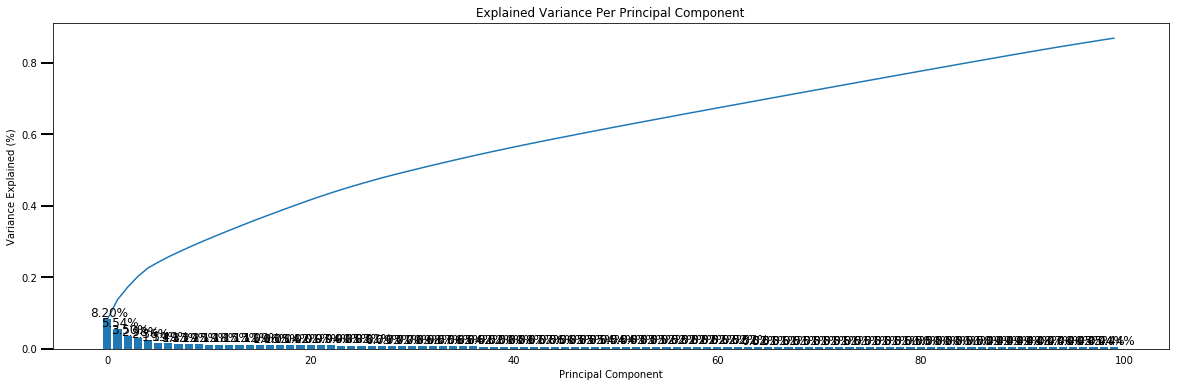

In [47]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=75)
pca_model = pca.fit(scaled_azdias)
pca_azdias = pca.transform(scaled_azdias)
pca_azdias_df = pd.DataFrame(pca_azdias)
pca_azdias_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,4.178900,-4.275376,-3.224942,1.651807,0.629551,1.879004,-0.372500,0.050505,-1.020223,2.171522,...,0.066228,0.770845,0.875977,-1.239824,1.404032,-1.736352,-0.259269,-1.076870,-0.257847,0.198611
1,-0.247880,-0.326761,-3.258352,-0.417598,-4.360815,1.714663,-1.140531,0.297791,-0.367199,-1.672277,...,-0.011342,0.165823,-0.204734,-0.043417,0.089762,-0.245399,0.214932,-0.578839,0.386874,-0.061844
2,-4.805087,2.012584,-1.343667,-1.987220,0.783035,-2.243851,1.073921,-1.246202,-0.304202,0.406129,...,-0.582317,0.326562,-0.101735,1.068432,0.835675,0.458211,-2.370738,1.763686,1.070540,-1.416611
3,-0.520307,0.153087,3.256392,2.845996,2.519391,2.173435,-3.456136,2.570723,-0.463741,-3.236975,...,-0.052159,-0.441950,-0.346540,0.018704,-0.283791,0.082608,0.424162,-0.894800,-0.313402,0.324107
4,-0.462517,-0.854508,-1.553244,-4.165424,-0.190356,2.858542,-2.365837,-0.431471,-0.315664,-0.170150,...,1.068187,-0.518368,-0.049706,-0.363077,0.170402,0.142970,-0.012570,-0.297392,0.194719,-1.324993


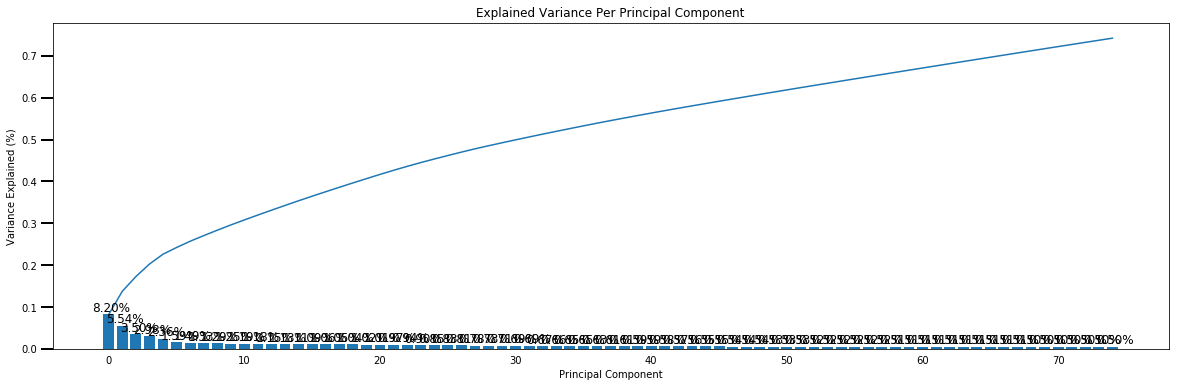

In [49]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

I first ran with 100 components and it resulted in 85% variance explained (cumulative).

I have decided to retain 75 components as it still retains about 75% of the variance explained (cumulative). This should help with analysis and still retain a pretty high level of variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
def map_weights(pca, df, num):    
    df_new = pd.DataFrame(pca.components_, columns=list(df.columns))
    
    # 0 index so need to subtract a number    
    return(df_new.iloc[num-1].sort_values(ascending=False))

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(map_weights(pca, scaled_azdias, 1))

LP_STATUS_GROB_1.0                0.188502
CAMEO_INTL_2015_TENS              0.181535
PLZ8_ANTG3                        0.181382
HH_EINKOMMEN_SCORE                0.180521
PLZ8_ANTG4                        0.176107
PLZ8_BAUMAX                       0.171853
ORTSGR_KLS9                       0.155227
EWDICHTE                          0.153635
FINANZ_HAUSBAUER                  0.147075
LP_STATUS_FEIN_1.0                0.128062
KBA05_ANTG4                       0.125878
PLZ8_ANTG2                        0.124285
ANZ_HAUSHALTE_AKTIV               0.114413
ARBEIT                            0.113050
KBA05_ANTG3                       0.111874
CAMEO_DEUG_2015_9                 0.110779
RELAT_AB                          0.106797
LP_STATUS_FEIN_2.0                0.104330
LP_FAMILIE_FEIN_1.0               0.099860
LP_FAMILIE_GROB_1.0               0.099860
FINANZTYP_1                       0.098938
FINANZ_SPARER                     0.094598
CAMEO_DEUG_2015_8                 0.091199
ZABEOTYP_5 

In [52]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca, scaled_azdias, 2))

ALTERSKATEGORIE_GROB            0.244443
FINANZ_VORSORGER                0.226880
ZABEOTYP_3                      0.203806
SEMIO_ERL                       0.188599
SEMIO_LUST                      0.170744
RETOURTYP_BK_S                  0.157412
W_KEIT_KIND_HH                  0.126390
CJT_GESAMTTYP_2.0               0.113231
FINANZ_MINIMALIST               0.105886
FINANZTYP_2                     0.103402
FINANZTYP_5                     0.095079
LP_STATUS_FEIN_1.0              0.081129
SHOPPER_TYP_3.0                 0.075963
SEMIO_KRIT                      0.075855
CJT_GESAMTTYP_1.0               0.073051
NATIONALITAET_KZ_1.0            0.072461
FINANZ_HAUSBAUER                0.071815
FINANZTYP_6                     0.068534
WOHNDAUER_2008                  0.058861
GFK_URLAUBERTYP_4.0             0.057976
LP_FAMILIE_FEIN_1.0             0.057638
LP_FAMILIE_GROB_1.0             0.057638
SEMIO_KAEM                      0.056223
LP_STATUS_FEIN_3.0              0.049719
EWDICHTE        

In [53]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca, scaled_azdias, 3))

SEMIO_VERT                        0.315789
SEMIO_FAM                         0.253509
SEMIO_SOZ                         0.252222
SEMIO_KULT                        0.245065
FINANZTYP_5                       0.136854
FINANZ_MINIMALIST                 0.135220
SHOPPER_TYP_0.0                   0.118644
ZABEOTYP_1                        0.118006
SEMIO_REL                         0.103418
SEMIO_MAT                         0.086200
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.086097
GREEN_AVANTGARDE                  0.085309
RETOURTYP_BK_S                    0.076947
ORTSGR_KLS9                       0.070178
EWDICHTE                          0.069648
LP_STATUS_GROB_5.0                0.062484
LP_STATUS_FEIN_10.0               0.062484
W_KEIT_KIND_HH                    0.060390
SHOPPER_TYP_1.0                   0.057328
PLZ8_BAUMAX                       0.054198
PLZ8_ANTG4                        0.052083
PLZ8_ANTG3                        0.051652
FINANZ_VORSORGER                  0.051635
ZABEOTYP_6 

### Discussion 2.3: Interpret Principal Components

Below are the positive and negative correlations for each of the first three principal components that had at least a 0.20 positive or -0.20 negative correlation. There are a lot of values but thought that would be a correlation threshold for the list below. It seems awfully low for a correlation but it is better than nothing!

Full results are above.

The definitions of these variables are pulled from the Data_Defition.md file provided:

______
Principal Component 1:
______

Positive:
LP_STATUS_GROB_1.0 (Social status, rough scale; low-income earner)
CAMEO_INTL_2015_TENS (German CAMEO: Wealth)
PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
HH_EINKOMMEN_SCORE (Estimated household net income)
PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)

Negative:
MOBI_REGIO (Movement patterns)

______
Principal Component 2:
______
Positive:
ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
FINANZ_VORSORGER (Financial typology)
ZABEOTYP_3 (Energy consumption typology; fair supplied)

Negative:
SEMIO_PFLICHT (Personality typology)
SEMIO_TRADV (Personality typology)
FINANZ_UNAUFFAELLIGER (Financial typology)
SEMIO_REL (Personality typology)
FINANZ_SPARER (Financial typology)

______
Principal Component 1:
______
Positive:
SEMIO_VERT (Personality typology)
SEMIO_FAM (Personality typology)
SEMIO_SOZ (Personality typology)
SEMIO_KULT (Personality typology)

Negative:
SEMIO_ERL (Personality typology)
SEMIO_VERT (Personality typology)
SEMIO_FAM (Personality typology)
SEMIO_SOZ (Personality typology)
SEMIO_KULT (Personality typology)

_____

I performed some initial research after tracking down this question which has some relevant information:
https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn/42867972#42867972

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
# Save to CSV files so I can reload them as I troubleshoot the code below
#pca_azdias.to_csv('pca_azdias.csv')
#scaled_azdias.to_csv('scaled_azdias.csv')
#azdias.to_csv('saved_azdias.csv')

In [55]:
# Load PCA from file to short circuit work
#pca_azdias = pd.read_csv('pca_azdias.csv')

In [56]:
# Note: I have used 'MiniBatchKMeans' because this is taking way too long with KMeans and I cannot finish the process
# without the workspace timing out with the full dataset. Found from here: https://stackoverflow.com/a/46515744/975592
#
# I found that the scores for MiniBatchKMeans aren't entirely consistent with running KMeans on the full dataset so
# hopefully this is consistent enough with the full KMeans algorithm.
#
# I have worked with a subset of data because it runs faster but as you can see below the results aren't entirely
# consistent there either.

In [57]:
# I've imported the helpers2.py file in that was provided with Lesson 1.10 (with slight modifications
# to be able to add in the start and end numbers)
centers, scores = h.fit_mods(pca_azdias[:100000], 1, 15, 1)

Starting analysis on 1 clusters...
Starting analysis on 2 clusters...
Starting analysis on 3 clusters...
Starting analysis on 4 clusters...
Starting analysis on 5 clusters...
Starting analysis on 6 clusters...
Starting analysis on 7 clusters...
Starting analysis on 8 clusters...
Starting analysis on 9 clusters...
Starting analysis on 10 clusters...
Starting analysis on 11 clusters...
Starting analysis on 12 clusters...
Starting analysis on 13 clusters...
Starting analysis on 14 clusters...


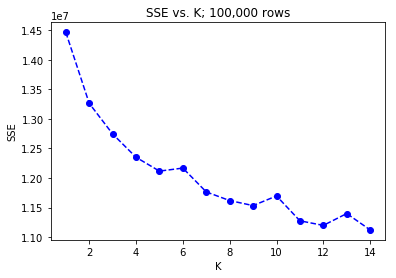

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# Referenced from Lesson 1.10
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K; 100,000 rows');

In [59]:
# I've imported the helpers2.py file in that was provided with Lesson 1.10 (with slight modifications
# to be able to add in the start and end numbers)
centers, scores = h.fit_mods(pca_azdias, 1, 15, 1)

Starting analysis on 1 clusters...
Starting analysis on 2 clusters...
Starting analysis on 3 clusters...
Starting analysis on 4 clusters...
Starting analysis on 5 clusters...
Starting analysis on 6 clusters...
Starting analysis on 7 clusters...
Starting analysis on 8 clusters...
Starting analysis on 9 clusters...
Starting analysis on 10 clusters...
Starting analysis on 11 clusters...
Starting analysis on 12 clusters...
Starting analysis on 13 clusters...
Starting analysis on 14 clusters...


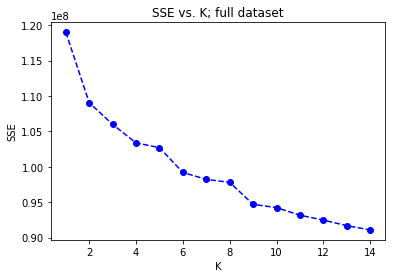

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# Referenced from Lesson 1.10
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K; full dataset');

In [61]:
# Go further
centers, scores = h.fit_mods(pca_azdias, 1, 150, 10)

Starting analysis on 1 clusters...
Starting analysis on 11 clusters...
Starting analysis on 21 clusters...
Starting analysis on 31 clusters...
Starting analysis on 41 clusters...
Starting analysis on 51 clusters...
Starting analysis on 61 clusters...
Starting analysis on 71 clusters...
Starting analysis on 81 clusters...
Starting analysis on 91 clusters...
Starting analysis on 101 clusters...
Starting analysis on 111 clusters...
Starting analysis on 121 clusters...
Starting analysis on 131 clusters...
Starting analysis on 141 clusters...


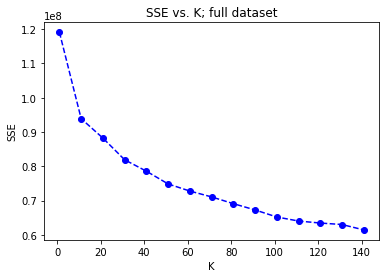

In [62]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K; full dataset');

In [64]:
# Not quite there yet, let's go one more step
centers, scores = h.fit_mods(pca_azdias, 1, 300, 10)

Starting analysis on 1 clusters...
Starting analysis on 11 clusters...
Starting analysis on 21 clusters...
Starting analysis on 31 clusters...
Starting analysis on 41 clusters...
Starting analysis on 51 clusters...
Starting analysis on 61 clusters...
Starting analysis on 71 clusters...
Starting analysis on 81 clusters...
Starting analysis on 91 clusters...
Starting analysis on 101 clusters...
Starting analysis on 111 clusters...
Starting analysis on 121 clusters...
Starting analysis on 131 clusters...
Starting analysis on 141 clusters...
Starting analysis on 151 clusters...
Starting analysis on 161 clusters...
Starting analysis on 171 clusters...
Starting analysis on 181 clusters...
Starting analysis on 191 clusters...
Starting analysis on 201 clusters...
Starting analysis on 211 clusters...
Starting analysis on 221 clusters...
Starting analysis on 231 clusters...
Starting analysis on 241 clusters...
Starting analysis on 251 clusters...
Starting analysis on 261 clusters...
Starting ana

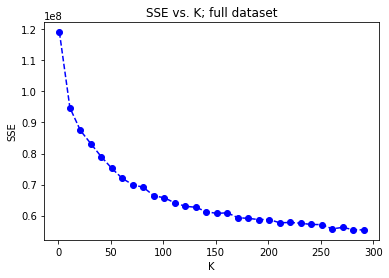

In [65]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K; full dataset');

In [68]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# We'll go with 300 as it looks to start leveling out around that point
final_cluster_count = 300

# It looks like it levels out after 75, so we will go with that
kmeans = MiniBatchKMeans(n_clusters=final_cluster_count)
y_preds = kmeans.fit_predict(pca_azdias)

In [69]:
print(pca_azdias.shape)

(817108, 75)


### Discussion 3.1: Apply Clustering to General Population

I found that KMeans took a very long time to run on large cluster amounts so I tried a couple methods:

• Used MiniBatchKmeans as a way to make the model faster to run. I found that the results weren't exactly consistent with KMeans but it was manageable.

• I then ran MiniBatchKMeans with a subset of the data (first 100,000 rows). It ran much more quickly but didn't get the full picture and find a leveling point. So I ran a few more times until the decrease slope started leveling out.

We will run with 300 clusters!

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [71]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [72]:
# Looks like only only column value is missing so I'll manually add it and then rerun
# Set all values to these columns to 0 since theoretically they would have no value since they did not exist

# Just a quick sanity check. If there are 10 or more missing columns, maybe we should dig deeper and see if
# there is a deeper problem
#assert len(column_difference) < 10, "More than 10 missing/different columns in customer data set. Please investigate further before proceeding."

#for difference in column_difference:
#    customers[difference] = 0

#test_customers = pd.get_dummies(customers, columns=multi_level_list)
#column_difference = list(set(encoded_column_names) - set(test_customers.columns.values))

#assert len(column_difference)==0, "There should be no differences in column."

In [92]:
# Let's re-run it
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers, feat_info)
imputed_customers = clean_nan_df(customers_clean)

In [93]:
# Upon an initial run, I found the columns are not exactly the same, though they should be. I check the differences
# and add the missing column names with a value of 0 through the dataframe

column_difference = list(set(imputed_azdias.columns.values) - set(imputed_customers.columns.values))

try:
    assert len(column_difference)==0
except:
    for difference in column_difference:
        imputed_customers[difference] = 0
    
    column_difference = list(set(imputed_azdias.columns.values) - set(imputed_customers.columns.values))

assert len(column_difference)==0, "There should not be any difference between azdias and customers columns."

In [94]:
# Apply StandardScaler
scaled_customers = pd.DataFrame(scaler_model.transform(imputed_customers), columns=imputed_customers.columns)
scaled_customers.columns = imputed_customers.columns

In [95]:
# Apply PCA to the data with 75 features
pca_customers = pca_model.transform(scaled_customers)

In [96]:
# For later recall / troubleshooting
#np.savetxt("pca_customers.csv", pca_customers, delimiter=",")

In [97]:
print(pca_customers.shape)

(144925, 75)


In [98]:
customer_y_preds = kmeans.predict(pca_customers)

In [163]:
print(customer_y_preds.shape)
print(customer_y_preds)

(144925,)
[ 35  74  25 ...,  35 232  35]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [138]:
def generate_cluster_percentages(pd_series):
    series_len = len(pd_series)
    series_counts = pd_series.value_counts()
    
    series_percentage_values = []
    for i, v in series_counts.items():
        series_percentage_values.append([i,(v/series_len)*100])
    
    return pd.DataFrame(series_percentage_values,columns=['Cluster', 'Percentage'])

Text(0.5,1,'Customer cluster percentages')

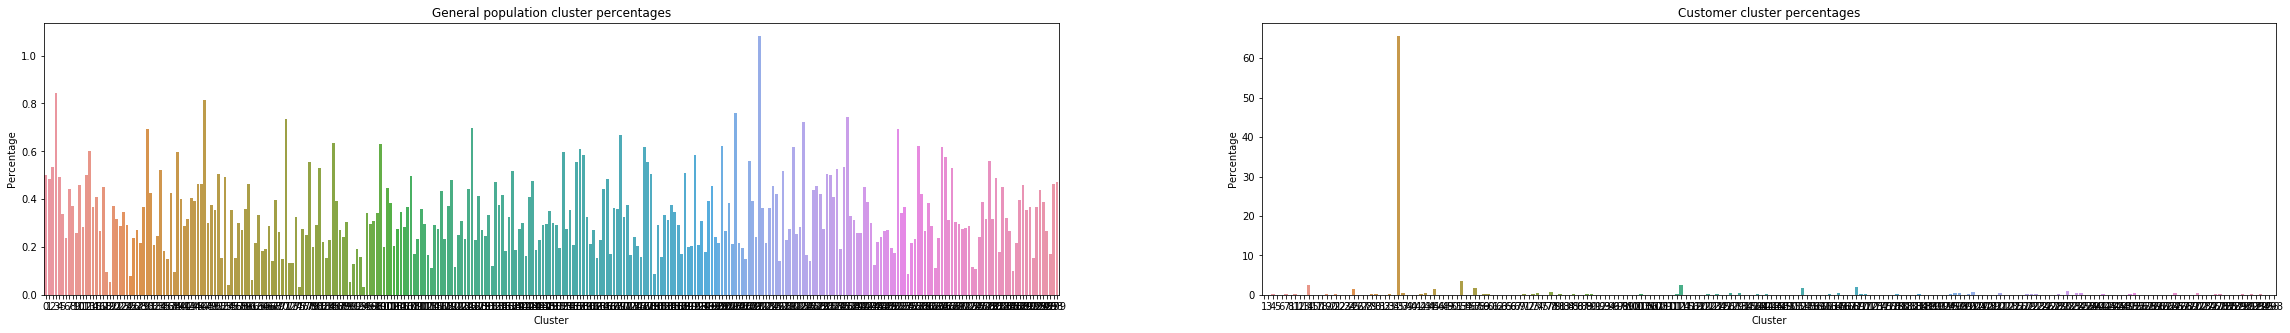

In [141]:
y_preds_series = pd.Series(y_preds)
customer_y_preds_series = pd.Series(customer_y_preds)

# Map percentages instead of raw counts    
y_preds_percentage_df = generate_cluster_percentages(y_preds_series)
customer_y_preds_percentage_df = generate_cluster_percentages(customer_y_preds_series)

fig, ax = plt.subplots(1,2,figsize=(40, 5))
sns.barplot(x="Cluster",y="Percentage", data=y_preds_percentage_df, ax=ax[0]).set_title("General population cluster percentages")
sns.barplot(x="Cluster",y="Percentage", data=customer_y_preds_percentage_df, ax=ax[1]).set_title("Customer cluster percentages")


In [160]:
# There are a lot of clusters so we'll write a little script to find the ones with the biggest difference.
# The way this is set up is that the lower difference (negative sum) is a bad target demo and the higher the difference
# (positive sum) is a good target demo
percentage_differences = []
for i in range(0,300):
    y_values = y_preds_percentage_df.loc[y_preds_percentage_df['Cluster']==i, 'Percentage'].values
    y_values = y_values[0] if len(y_values > 0) else 0
    
    c_values = customer_y_preds_percentage_df.loc[y_preds_percentage_df['Cluster']==i,'Percentage'].values
    c_values = c_values[0] if len(c_values > 0) else 0
    
    p_difference = c_values - y_values
    percentage_differences.append([y_values, c_values, p_difference])
    
differences_df = pd.DataFrame(percentage_differences,columns=['General %', 'Customer %', 'Difference'], index=range(0,300))
differences_df = differences_df.sort_values('Difference', ascending=False)
print(differences_df)

     General %  Customer %  Difference
211   1.082476   65.659479   64.577003
3     0.842606    3.556322    2.713716
204   0.759875    2.399172    1.639297
47    0.815804    2.412972    1.597168
237   0.743843    1.905123    1.161280
71    0.735154    1.661549    0.926395
224   0.720835    1.645679    0.924844
126   0.695991    1.419355    0.723364
252   0.695012    1.392444    0.697432
30    0.694890    1.014318    0.319428
85    0.634922    0.814214    0.179292
170   0.670168    0.828705    0.158536
75    0.032554    0.000000   -0.032554
94    0.034022    0.000000   -0.034022
54    0.040509    0.000000   -0.040509
90    0.053604    0.000000   -0.053604
19    0.054093    0.000000   -0.054093
61    0.063517    0.000000   -0.063517
200   0.623908    0.556840   -0.067068
258   0.620236    0.550630   -0.069607
99    0.629904    0.559600   -0.070305
221   0.619869    0.545800   -0.074070
25    0.076856    0.000000   -0.076856
255   0.085790    0.000000   -0.085790
180   0.086769    0.00000

In [161]:
# Clusters 211, 3 and 204 are the strongest target customers
# Clusters 125, 165, 7 are the weakest target customers
# Let's get some info on them

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# It appears cluster 2 and cluster 6 are target customer bases as they have a much higher percentage than
# the general population. Let's find out who they are!
cluster_211 = map_weights(pca, scaled_customers, 211)
print("===========")
print("Cluster 211 details:")
print("===========")
print(cluster_211[cluster_211 > 0.21])
print(cluster_211[cluster_211 < -0.21])

cluster_3 = map_weights(pca, scaled_customers, 3)
print("===========")
print("Cluster 3 details:")
print("===========")
print(cluster_3[cluster_3 > 0.21])
print(cluster_3[cluster_3 < -0.21])


IndexError: single positional indexer is out-of-bounds

In [82]:
# For troubleshoointg
#np.savetxt("y_preds.csv", y_preds, delimiter=",")
#np.savetxt("customer_y_preds.csv", customer_y_preds, delimiter=",")

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.